#Sales Forecasting with ARIMA Model
This notebook contains a step-by-step guide to forecasting sales using an ARIMA model. The data used in this analysis is a time series of daily sales data from January 2016 to February 2023. The goal is to create an ARIMA model that can accurately predict future sales.

##Data Preparation
The first step in creating an ARIMA model is to prepare the data. In this case, the data is loaded from a CSV file, the Date column is converted to a datetime datatype, and the total sales per day are obtained by grouping the data by date and summing the sales for each day. The data is then resampled to daily frequency and plotted to visualize the trend.

##Stationarity Testing
In order to use an ARIMA model, the time series must be stationary, meaning it has constant statistical properties over time. To test for stationarity, the test_stationarity function is used to plot the rolling mean and standard deviation, and to perform a Dickey-Fuller test. The differencing term is then calculated, and the ACF and PACF plots are used to determine the order of the AR and MA terms.

##Model Fitting and Prediction
The auto_arima function from the pmdarima package is used to automatically determine the optimal order of the ARIMA model. The data is then split into training and testing sets, and the ARIMA model is fit on the training data using the ARIMA function from the statsmodels.tsa.arima.model package. The predict function is then used to generate predictions on the test data, and the model is evaluated using metrics such as mean squared error (MSE) and mean absolute error (MAE). Finally, the actual and predicted values are plotted to visualize the model performance.

##Model Improvement
To improve the model performance, several techniques can be used. One such technique is to incorporate external factors such as holidays and events that may affect sales. Another technique is to try different models such as SARIMA, which includes a seasonal component, or Prophet, a forecasting model developed by Facebook that can handle seasonality and non-linear trends.

Overall, the ARIMA model provides a useful tool for forecasting sales data. However, it's important to keep in mind that the accuracy of the model depends on the quality of the data and the assumptions made about the underlying process.

Step 1: Data Preprocessing
Importing necessary libraries

In [ ]:
!pip install statsmodels
!pip install pmdarima


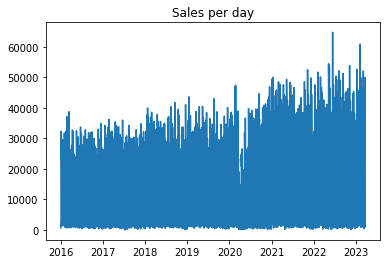

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Load data and convert Date column to datetime datatype
sales = pd.read_csv('2016-Mar222023.csv')
sales['Date'] = pd.to_datetime(sales['Date'])

# Create a new dataframe to obtain total sales per day
sales_data = sales[['Date', 'Total']]
sales_data = sales_data.groupby('Date')['Total'].sum().reset_index()
sales_data.set_index('Date', inplace=True)

# Resample the data to daily frequency
sales_data = sales_data.resample('D').sum()

# Plot the sales per day to visualize the trend
plt.plot(sales_data)
plt.title("Sales per day")
plt.show()



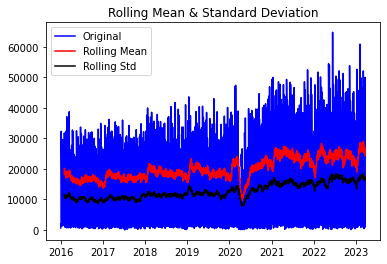

ADF Statistic: -3.2042924242293047
p-value: 0.019737557426035862
Critical Values:
	1%: -3.4328579475395395
	5%: -2.8626480184291183
	10%: -2.567359837641843
Time series is stationary


In [ ]:
# Convert the time series to stationary
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Determine rolling statistics
    rolling_mean = timeseries.rolling(window=30).mean()
    rolling_std = timeseries.rolling(window=30).std()
    
    # Plot rolling statistics
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key,value))
    
     # Check for stationarity
    if result[0] < result[4]["5%"] and result[1] < 0.05:
        print("Time series is stationary")
    else:
        print("Time series is not stationary")
        
test_stationarity(sales_data)

# Difference the time series to make it stationary
sales_data_diff = sales_data.diff(periods=1).dropna()

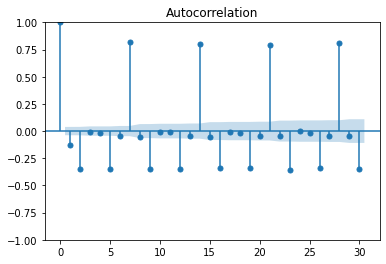

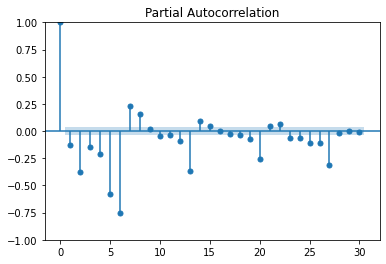

Estimated differencing term: 1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=57925.898, Time=1.88 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=58328.767, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=57925.469, Time=2.03 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=56776.057, Time=17.51 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=58326.768, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=3.93 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=15.34 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=26.55 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=57155.878, Time=8.02 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=26.09 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=57008.518, Time=4.33 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=56664.081, Time=5.58 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=3.24 sec
 ARIMA(0,0,2)(1,0,1)[12] intercept   : AIC=56633.369, Time=8.80 sec


In [ ]:
#1. Plot the ACF and PACF of the stationary time series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(sales_data_diff, lags=30)
plot_pacf(sales_data_diff, lags=30)
plt.show()

#2. Determine the order of differencing needed to make the time series stationary
from pmdarima.arima.utils import ndiffs

kpss_diffs = ndiffs(sales_data, test='kpss')
adf_diffs = ndiffs(sales_data, test='adf')
n_diffs = max(adf_diffs, kpss_diffs)
print("Estimated differencing term:", n_diffs)

#3. Determine the order of AR and MA terms based on the ACF and PACF plots
#If ACF has a sharp drop after lag k and PACF has a sharp cutoff after lag m, then start with ARIMA(k,0,m)
#If ACF has a gradual decrease and PACF has a gradual cutoff, then start with ARIMA(p,d,q) where d is the differencing term
#You can also use the auto_arima function from pmdarima to automatically determine the optimal order
from pmdarima.arima import auto_arima

model = auto_arima(sales_data_diff, start_p=0, start_q=0,
                  test='adf',       # use adftest to find optimal 'd'
                  max_p=3, max_q=3, # maximum p and q
                  m=12,              # frequency of series
                  d=None,           # let model determine 'd'
                  seasonal=True,    # No Seasonality
                  start_P=0, 
                  D=0, 
                  trace=True,
                  error_action='ignore',  
                  suppress_warnings=True, 
                  stepwise=True)

print(model.summary())


In [ ]:
#4. Split the data into training and testing sets
train_data = sales_data[:'2023-03-14']
test_data = sales_data['2023-03-14':]

#5. Fit the ARIMA model on the training data
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_data, order=model.order).fit()


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
#6. Generate predictions on the test data using the fitted model
predictions = arima_model.predict(start='2023-03-14', end='2023-03-22', typ='levels')


MSE: 127694843.07727316
MAE: 8476.127834190844


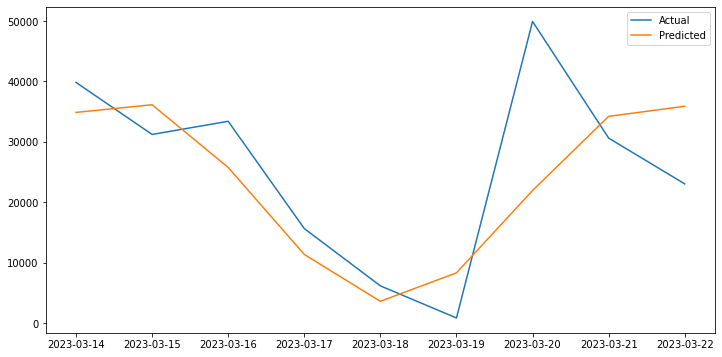

In [ ]:
#7. Evaluate the model using metrics such as MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test_data, predictions)
mae = mean_absolute_error(test_data, predictions)
print("MSE:", mse)
print("MAE:", mae)

#8. Visualize the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data.values, label='Actual')
plt.plot(predictions.index, predictions.values, label='Predicted')
plt.legend()
plt.show()

In [ ]:
predictions

2023-03-14    34876.264040
2023-03-15    36146.314179
2023-03-16    25762.507830
2023-03-17    11359.750973
2023-03-18     3602.498252
2023-03-19     8320.699374
2023-03-20    21951.742344
2023-03-21    34224.171632
2023-03-22    35897.348761
Freq: D, Name: predicted_mean, dtype: float64